# Compare the difference in elevation between DEM and Icesat-2 Data
REMA  

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (15, 8), 'font.size': 10})

from shapely.geometry import Polygon, Point
import hvplot
import geoviews as gv

import xarray as xr

import rasterio as rio
import hvplot.pandas
import hvplot.xarray

In [3]:
#base_region = #'REMA'

#data5: region_19_victoria_land  region_21_mbl_north  region_22_mbl_central     region_24_ctam
#data4: region_01_subantarctic_islands region_02_peninsula_north region_03_peninsula_south
#project: R:\REMA\region_20_ross_shelf\strips_unf\2m

region = 'region_03_peninsula_south'#'hma_2019jun26' #'region_20_ross_shelf'

In [4]:
# Select strips from icesat-2 because we know we have data (this is opposite of what we did in downloading data)
base_icesat2_path = f'/fs/byo/howat-data5/icesat2/rema/{region}'

In [5]:
strips = os.listdir(base_icesat2_path)
len(strips)

102

In [6]:
strips[:5]

['GE01_20181022_1050010012B24800_1050010012B24A00_2m_lsf',
 'GE01_20181122_10500100133E2100_10500100133E2200_2m_lsf',
 'W1W1_20190406_1020010082B4AA00_10200100830E3500_2m_lsf',
 'WV01_20181212_102001007B3BC200_102001007CD19800_2m_lsf',
 'WV01_20181215_102001007E226D00_10200100809E6900_2m_lsf']

In [7]:
# Select a particular satellite, WV03 for example
strips = [strip for strip in strips if strip.startswith('WV03')]
len(strips)

21

In [8]:
# Set the icesat2_path : where files will be downloaded and processed (created inside code)
#base_icesat2_path = f'{dir_prefix}/icesat2/rema/{region}' # chage output folder
#base_icesat2_path = f'/fs/byo/howat-data5/icesat2/rema/{region}' # hard-coded to data5; f'/fs/byo/howat-data5/icesat2/EarthDEM/{region}' FUTURE ref
#base_icesat2_path = f'/fs/byo/howat-data5/icesat2/hma/{region}' # hard-coded to data5; f'/fs/byo/howat-data5/icesat2/EarthDEM/{region}' FUTURE ref

In [9]:
# strip = 'GE01_20181122_10500100133E2100_10500100133E2200_2m_lsf' #'GE01_20181022_1050010012B24800_1050010012B24A00_2m_lsf'##
#icesat2_path = f'D:/icesat2/rema/region_03_peninsula_south_2/{strip}'
# icesat2_path = f'/fs/byo/howat-data5/icesat2/rema/region_03_peninsula_south/{strip}'

## Choose a DEM strip for Analysis

In [9]:
strip = strips[10]
print(strip)
icesat2_path = f'/fs/byo/howat-data5/icesat2/rema/{region}/{strip}'
os.path.exists(icesat2_path)

WV03_20181016_1040010044423500_104001004399BD00_2m_lsf


True

In [10]:
icesat2_path

'/fs/byo/howat-data5/icesat2/rema/region_03_peninsula_south/WV03_20181016_1040010044423500_104001004399BD00_2m_lsf'

In [11]:
files = os.listdir(f'{icesat2_path}')

In [12]:
files

['strip_outline.shp',
 'strip_outline.shx',
 'strip_outline.dbf',
 'strip_outline.cpg',
 'strip_outline.prj',
 'processed_ATL06_20181026065607_04220110_002_01.h5',
 'processed_ATL06_20181030064749_04830110_002_01.h5',
 'processed_ATL06_20181025200930_04150112_002_01.h5',
 'processed_ATL06_20181021201748_03540112_002_01.h5',
 'processed_ATL06_20181026065607_04220110_002_01.csv',
 'processed_ATL06_20181026065607_04220110_002_01.cpg',
 'processed_ATL06_20181030064749_04830110_002_01.csv',
 'processed_ATL06_20181030064749_04830110_002_01.cpg',
 'processed_ATL06_20181025200930_04150112_002_01.csv',
 'processed_ATL06_20181025200930_04150112_002_01.cpg',
 'processed_ATL06_20181021201748_03540112_002_01.csv',
 'processed_ATL06_20181021201748_03540112_002_01.cpg',
 'processed_ATL06_20181026065607_04220110_002_01.shp',
 'processed_ATL06_20181026065607_04220110_002_01.shx',
 'processed_ATL06_20181026065607_04220110_002_01.dbf',
 'processed_ATL06_20181026065607_04220110_002_01.prj',
 'processed_AT

In [13]:
outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')
# hdf_files = [f for f in files if f.endswith('.h5')]
shp_files = [f for f in files if f.endswith('.shp') and 'ATL06' in f]
shp_files

['processed_ATL06_20181026065607_04220110_002_01.shp',
 'processed_ATL06_20181030064749_04830110_002_01.shp',
 'processed_ATL06_20181025200930_04150112_002_01.shp',
 'processed_ATL06_20181021201748_03540112_002_01.shp']

In [14]:
outline

,name,time1,time2,seg_id,geometry
0,WV03_20181016_1040010044423500_104001004399BD0...,20181016131606,20181016131721,1,"POLYGON ((-68.58537 -75.80415, -68.58567 -76.0..."
1,WV03_20181016_1040010044423500_104001004399BD0...,20181016131606,20181016131720,2,"POLYGON ((-69.09520 -75.97999, -69.09521 -75.9..."


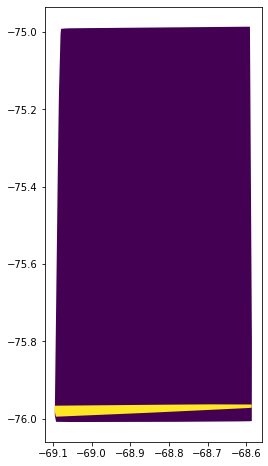

In [16]:
outline.plot(column='seg_id');

## Now get the DEM (Rema for example)

In [17]:
#dir_prefix = '/fs/byo/howat-data5' #data4, 5 'D:' 'V:'
dir_prefix = '/fs/byo/howat-data4' #'/fs/project/howat.4' #/REMA/region_20_ross_shelf
# dem_folder = f'D:/REMA/region_03_peninsula_south/strips_unf/2m/{strip}'
dem_folder = f'{dir_prefix}/REMA/{region}/strips_unf/2m/{strip}'
tifs = [tif for tif in os.listdir(dem_folder) if tif.endswith('.tif')]
tifs

['WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg1_dem.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg1_ortho.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg1_dem_10m.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg2_dem.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg2_ortho.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg1_matchtag.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg1_bitmask.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg1_dem_browse.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg2_dem_10m.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg2_dem_browse.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg2_bitmask.tif',
 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg2_matchtag.tif']

In [19]:
# Can have one or more DEMs depending on how it was produced
dem_tif = [tif for tif in os.listdir(dem_folder) if tif.endswith('_dem.tif')]
print(dem_tif)
dem_tif = dem_tif[0] #Choose one DEM (or better find a way to merge; but this will also significantly increase the size of data)
dem_tif

['WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg1_dem.tif', 'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg2_dem.tif']


'WV03_20181016_1040010044423500_104001004399BD00_2m_lsf_seg1_dem.tif'

In [20]:
import georasters as grs

In [21]:
# dem_tif = 'WV03_20181027_104001004420C800_104001004477D800_2m_lsf_seg1_dem_10m.tif' # hard coded

In [22]:
dem = grs.from_file(f'{dem_folder}/{dem_tif}')

In [23]:
# use xarray only for visualization
da = xr.open_rasterio(f'{dem_folder}/{dem_tif}')
nodata_value = da.attrs['nodatavals'][0]
da.data[da.data==nodata_value] = np.nan
print(nodata_value)

-9999.0


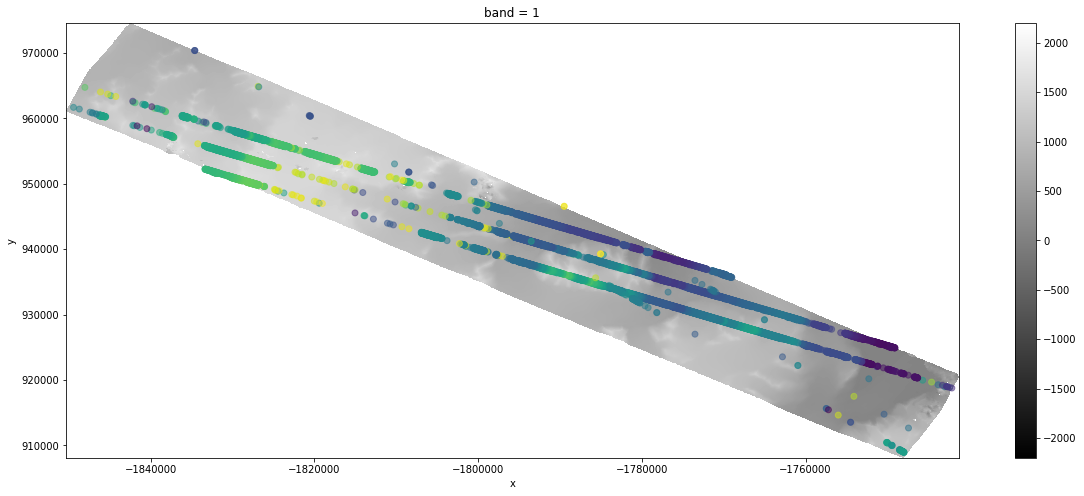

In [26]:
# Plot ATL data on top of DEM
proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #rema 
# Read ATL Shapefile
fig, ax = plt.subplots(figsize=(20, 8))
for shp in shp_files:
    gdf = gpd.read_file(f'{icesat2_path}/{shp}')
    gdf = gdf.to_crs(proj4)
    gdf.plot(column='h_li', ax=ax, alpha=.5)
da.sel(band=1).plot.imshow(ax=ax, cmap='gray')
# dem.plot(ax=ax, cmap='gray')

processed_ATL06_20181026065607_04220110_002_01.shp
301


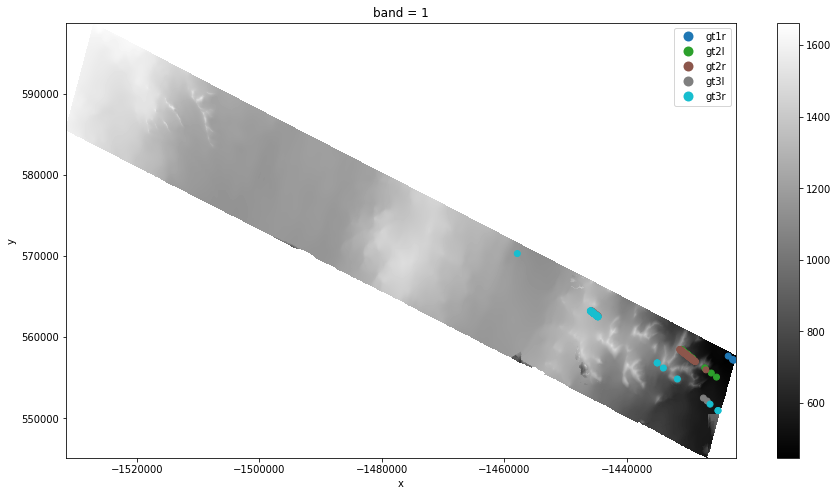

In [24]:
# Read ATL Shapefile
shp = shp_files[0]#'processed_ATL06_20181126061504_08950110_002_01.shp' [4, 6]
print(shp)
gdf = gpd.read_file(f'{icesat2_path}/{shp}')
print(len(gdf))

# Reproject the shapefile to that of REMA
proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #rema 
# proj4 = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' #arcticDEM
# gdf = gdf.to_crs({'init': 'epsg:4326'}) #change to lat/longitude
gdf = gdf.to_crs(proj4)
ax = gdf.plot(column='strip', legend=True)
da.sel(band=1).plot.imshow(ax=ax, cmap='gray')
# gdf.head(2)

In [25]:
# print(dem.projection.ExportToPrettyWkt())

In [26]:
# Initilize dem elevlation
# gdf['dem'] = np.nan

In [27]:
def getPixVal(geom):
    #dem.map_pixel(x, y)
    coords = geom.coords[0]
    x, y = coords
    return(dem.map_pixel(x, y))

gdf['dem'] = gdf.geometry.apply(getPixVal)
# gdf = gdf.iloc[6:-10]
gdf['dif'] = gdf.h_li-gdf.dem

In [28]:
gdf

,t_dt,h_li,q_flag,strip,geometry,dem,dif
0,2018-10-26 07:03:38.025000,2653.736572,1,gt1r,POINT (-1423454.383 557666.403),457.564850,2196.171722
1,2018-10-26 07:03:38.143000,2803.203613,1,gt1r,POINT (-1422743.405 557247.146),456.376434,2346.827179
2,2018-10-26 07:03:38.146000,2804.654053,1,gt1r,POINT (-1422726.496 557237.139),456.043457,2348.610596
3,2018-10-26 07:03:38.172000,2808.986328,1,gt1r,POINT (-1422574.304 557147.029),451.811157,2357.175171
4,2018-10-26 07:03:36.637000,969.286743,1,gt2l,POINT (-1431144.607 558475.445),969.427002,-0.140259
...,...,...,...,...,...,...,...
296,2018-10-26 07:03:36.786000,386.290802,1,gt3r,POINT (-1434041.654 556198.448),1060.845581,-674.554779
297,2018-10-26 07:03:37.168000,-321.367645,1,gt3r,POINT (-1431755.955 554843.641),1029.249756,-1350.617401
298,2018-10-26 07:03:38.050000,3184.180664,1,gt3r,POINT (-1426421.213 551739.393),554.263916,2629.916748
299,2018-10-26 07:03:38.269000,1047.343628,1,gt3r,POINT (-1425127.907 550953.088),544.805786,502.537842


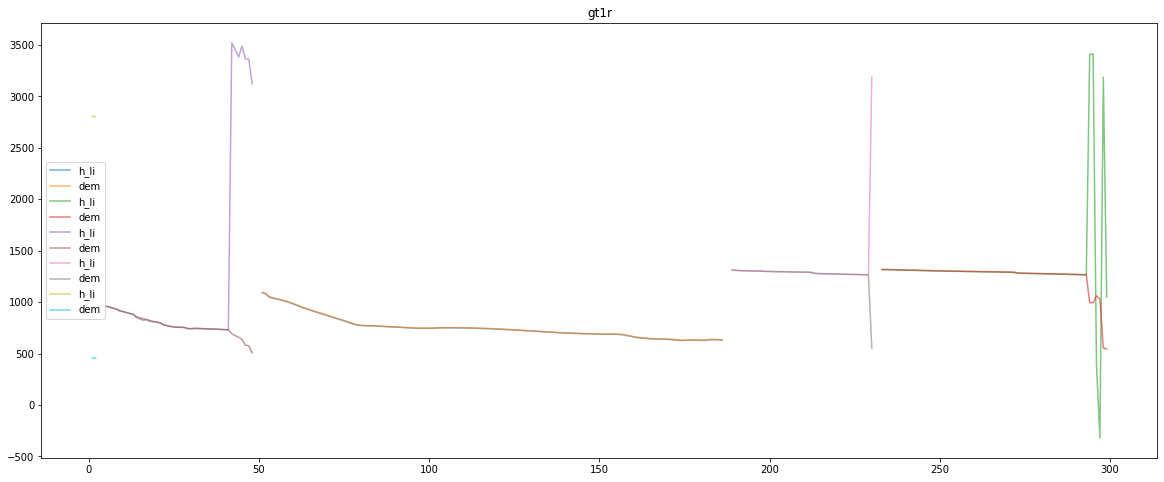

In [29]:
strips = list(gdf.strip.value_counts().index) #['gt1l', 'gt1r','gt2l', 'gt2r', 'gt3l','gt3r']
# strip = strips[2]
fig, ax = plt.subplots(figsize=(20, 8))
for strip in strips:
    gdf[gdf.strip==strip][['h_li', 'dem']].iloc[1:-1].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

In [30]:
# len(strips)
strips

['gt2r', 'gt3r', 'gt2l', 'gt3l', 'gt1r']

In [31]:
gdf0 = gdf[gdf.q_flag==0]
gdf0

,t_dt,h_li,q_flag,strip,geometry,dem,dif
11,2018-10-26 07:03:36.660000,899.799072,0,gt2l,POINT (-1431009.301 558395.325),898.130371,1.668701
24,2018-10-26 07:03:36.705000,762.851624,0,gt2l,POINT (-1430738.441 558235.495),763.530701,-0.679077
26,2018-10-26 07:03:36.711000,754.801025,0,gt2l,POINT (-1430704.591 558215.497),756.097351,-1.296326
27,2018-10-26 07:03:36.716000,753.822693,0,gt2l,POINT (-1430670.724 558195.533),754.852478,-1.029785
28,2018-10-26 07:03:36.719000,753.452576,0,gt2l,POINT (-1430653.795 558185.550),754.163757,-0.711182
...,...,...,...,...,...,...,...
289,2018-10-26 07:03:34.999000,1267.872681,0,gt3r,POINT (-1444771.707 562535.991),1269.312866,-1.440186
290,2018-10-26 07:03:35.001000,1267.052734,0,gt3r,POINT (-1444754.790 562525.975),1268.504639,-1.451904
291,2018-10-26 07:03:35.004000,1266.222900,0,gt3r,POINT (-1444737.868 562515.954),1267.582397,-1.359497
292,2018-10-26 07:03:35.007000,1265.389526,0,gt3r,POINT (-1444720.953 562505.928),1266.833374,-1.443848


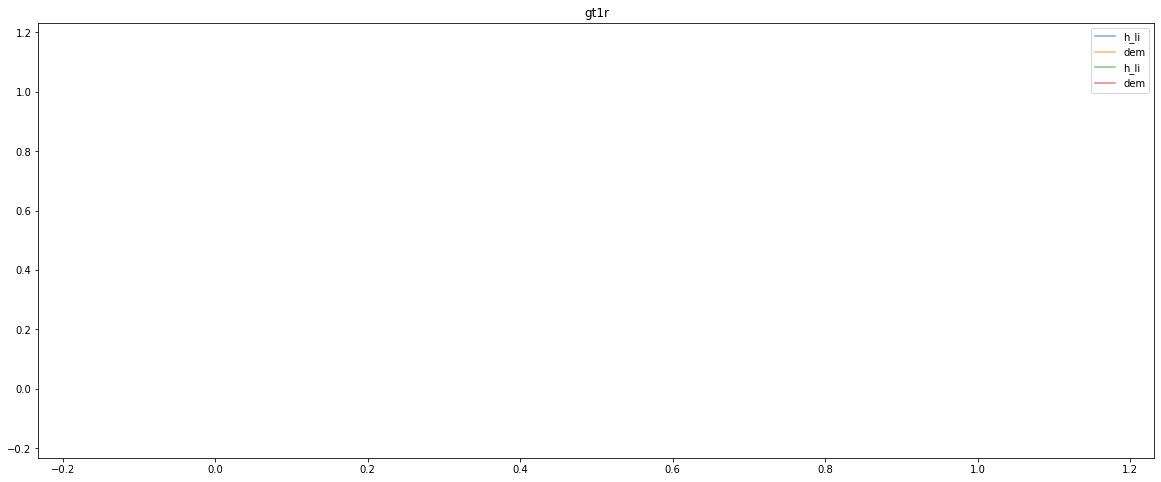

In [33]:
# gdf[['h_li', 'dem']].plot()
fig, ax = plt.subplots(figsize=(20, 8))
gdf0[gdf0.strip=='gt1l'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax
gdf0[gdf0.strip=='gt1r'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

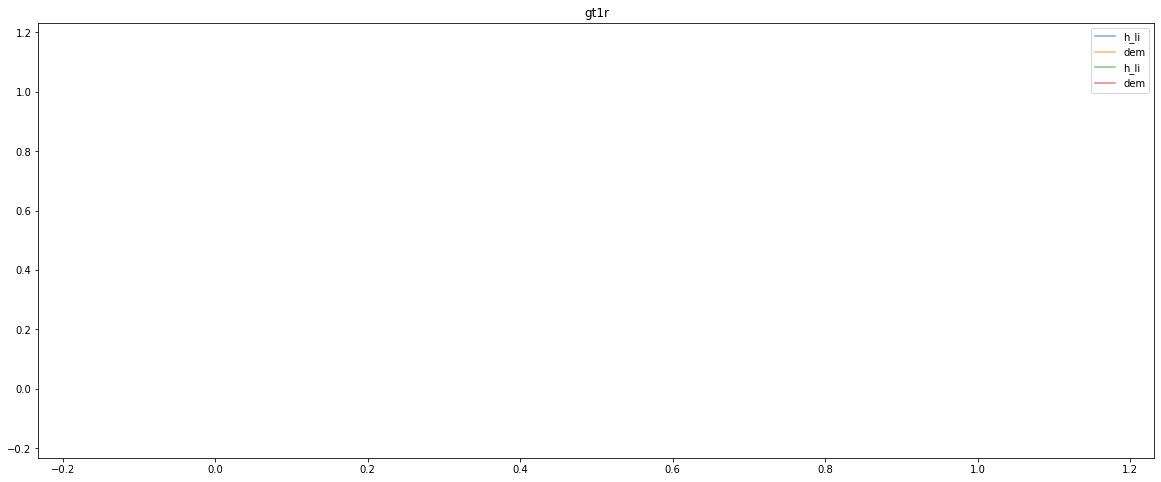

In [34]:
fig, ax = plt.subplots(figsize=(20, 8))

gdf[gdf.strip=='gt1l'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax
gdf[gdf.strip=='gt1r'][['h_li', 'dem']].reset_index(drop=True).iloc[10:-10].plot(style='-', alpha=.6, title=strip, ax=ax); #, ax=ax

In [36]:
# gdf0[gdf0.strip=='gt1l'].reset_index(drop=True)

In [37]:
# gdf.dif.plot()

In [38]:
gdf.strip.value_counts()

gt2r    138
gt3r     69
gt2l     46
gt3l     44
gt1r      4
Name: strip, dtype: int64

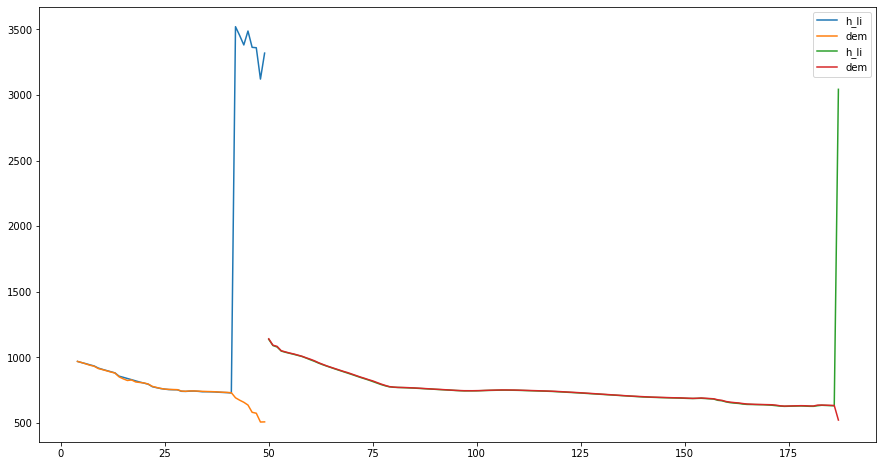

In [39]:
strip = 'gt2'
ax = gdf[gdf.strip==f'{strip}l'][['h_li', 'dem']].plot()
gdf[gdf.strip==f'{strip}r'][['h_li', 'dem']].plot(ax = ax)

In [40]:
gdf

,t_dt,h_li,q_flag,strip,geometry,dem,dif
0,2018-10-26 07:03:38.025000,2653.736572,1,gt1r,POINT (-1423454.383 557666.403),457.564850,2196.171722
1,2018-10-26 07:03:38.143000,2803.203613,1,gt1r,POINT (-1422743.405 557247.146),456.376434,2346.827179
2,2018-10-26 07:03:38.146000,2804.654053,1,gt1r,POINT (-1422726.496 557237.139),456.043457,2348.610596
3,2018-10-26 07:03:38.172000,2808.986328,1,gt1r,POINT (-1422574.304 557147.029),451.811157,2357.175171
4,2018-10-26 07:03:36.637000,969.286743,1,gt2l,POINT (-1431144.607 558475.445),969.427002,-0.140259
...,...,...,...,...,...,...,...
296,2018-10-26 07:03:36.786000,386.290802,1,gt3r,POINT (-1434041.654 556198.448),1060.845581,-674.554779
297,2018-10-26 07:03:37.168000,-321.367645,1,gt3r,POINT (-1431755.955 554843.641),1029.249756,-1350.617401
298,2018-10-26 07:03:38.050000,3184.180664,1,gt3r,POINT (-1426421.213 551739.393),554.263916,2629.916748
299,2018-10-26 07:03:38.269000,1047.343628,1,gt3r,POINT (-1425127.907 550953.088),544.805786,502.537842


In [41]:
# Convert back to lat-lon for plotting
gdf = gdf.to_crs({'init': 'epsg:4326'})
gv.tile_sources.ESRI * gdf.hvplot(geo=True, color='strip', width=700, height=700)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (strip)

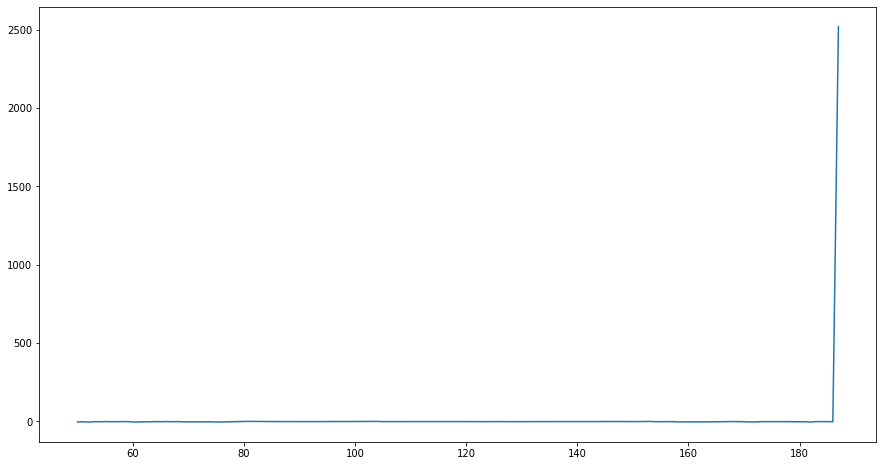

In [42]:
gdf[gdf.strip==f'{strip}r'].dif.plot()

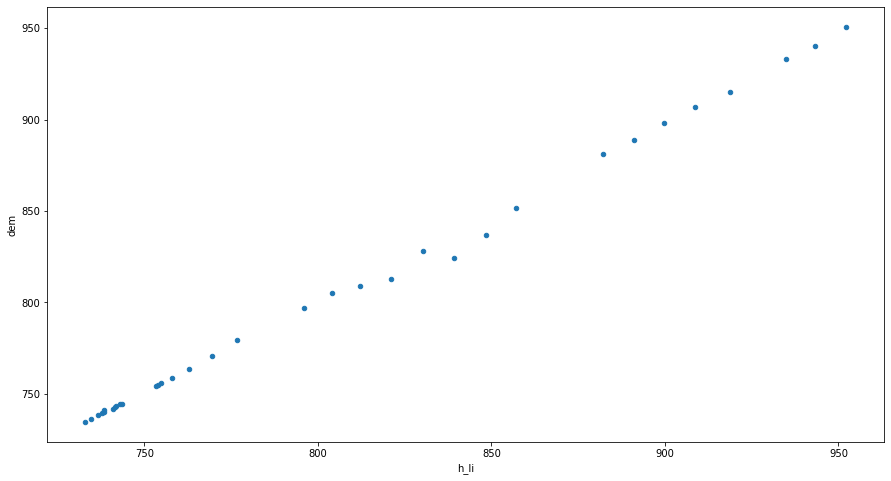

In [43]:
gdf[gdf.strip==f'{strip}l'][['h_li', 'dem']].iloc[2:-10].plot(kind='scatter', x=0, y=1)